# MoDISco: Motif Discovery from Importance Scores

## Loading the tracks

We begin by loading all the tracks to be used in the clustering. In this example, we use scores obtained using DeepLIFT on the talgata simulation from the DeepLIFT paper (https://arxiv.org/abs/1704.02685). We restrict the analysis to scores for the "both TAL and GATA" task on the positive examples from the testing set. See the notebook under `generate_scores` for the code to produce these tracks.

We will be intersted in three types of tracks: the DeepLIFT contribution scores, the multipliers, and the one-hot encoding.
- The DeepLIFT contribution scores tell us how much each base in the sequence contributed to the final prediction. We will use these contribution scores to identify segments of high importance (dubbed "seqlets")
- The multipliers, which are also obtained from the DeepLIFT package, act like an 'autocomplete' of the motifs; they give us a sense not just of the network's preference for the bases that were present, but also for the bases that were absent. This helps us extract more information that can improve the clustering. Although not shown in this example, it is also possible to use data from other layers of the network, such as importance scores on the first convolutional layer.
- The one-hot encoding is not used in either seqlet identification or in clustering, but we keep track of it in order to obtain a PWM-type representation of the MoDISco motifs at the end

In [1]:
from __future__ import division, print_function

!./grab_data.sh

%matplotlib inline
import numpy as np
import h5py
multipliers = np.array(h5py.File("talgata_task0_positives_multipliers.hdf5","r")["/values"])
deeplift_scores = np.array(h5py.File("talgata_task0_positives_scores.hdf5","r")["/values"])
print(multipliers.shape)
print(deeplift_scores.shape)

#We mean normalize multipliers at each position for ease of visualization and clustering
#note: this is not the theoretically best thing to do, but is nice and quick;
#the theoretically best thing would be to estimate contributions for each of the 4 possible
#one-hot encodings using multipliers*[hypothetical difference-from-reference] at each position.
multipliers = multipliers-np.mean(multipliers,axis=2)[:,:,None]

#extract the one-hot encoding using the DeepLIFT track
onehot_seq = (np.abs(deeplift_scores) > 0)*1.0

#concatenate with reverse complement to demonstrate that MoDISco can
#handle reverse complements
multipliers = np.concatenate([multipliers, multipliers[:,::-1,::-1]], axis=0)
deeplift_scores = np.concatenate([deeplift_scores, deeplift_scores[:,::-1,::-1]], axis=0)
onehot_seq = np.concatenate([onehot_seq, onehot_seq[:,::-1,::-1]], axis=0)

--2017-09-05 01:35:52--  https://github.com/AvantiShri/model_storage/raw/0bdb4aa9ec06ba272ed531e7d9ea40c277de780f/modisco/talgata_task0_positives_multipliers.hdf5
Resolving github.com... 192.30.255.112, 192.30.255.113
Connecting to github.com|192.30.255.112|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/AvantiShri/model_storage/0bdb4aa9ec06ba272ed531e7d9ea40c277de780f/modisco/talgata_task0_positives_multipliers.hdf5 [following]
--2017-09-05 01:35:53--  https://raw.githubusercontent.com/AvantiShri/model_storage/0bdb4aa9ec06ba272ed531e7d9ea40c277de780f/modisco/talgata_task0_positives_multipliers.hdf5
Resolving raw.githubusercontent.com... 151.101.188.133
Connecting to raw.githubusercontent.com|151.101.188.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1512544 (1.4M) [application/octet-stream]
Saving to: 'talgata_task0_positives_multipliers.hdf5'

100%[======================================>] 

As a sanity-check, we visualize the DeepLIFT contribution scores and the multipliers for a sequence. Note how the multipliers give information about the bases that were not present in the sequence.

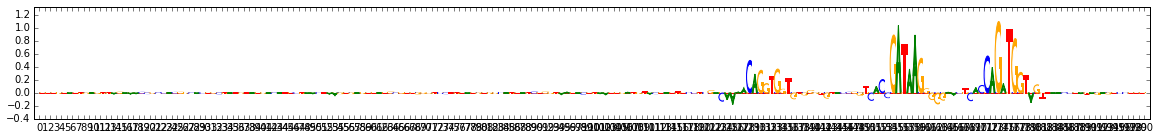

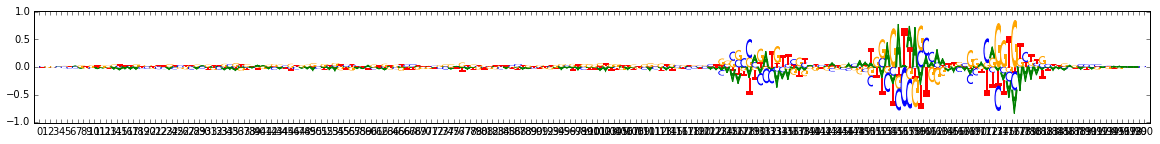

In [2]:
from modisco.visualization import viz_sequence
viz_sequence.plot_weights(deeplift_scores[0])
viz_sequence.plot_weights(multipliers[0])

We prepare `DataTrack` objects that will contain all the numpy arrays we will use for MoDISco, and collect them together into a single `TrackSet` object.

In [3]:
from modisco import core
reload(core)
deeplift_score_track = core.DataTrack(name="deeplift_scores", fwd_tracks=deeplift_scores,
                             rev_tracks=deeplift_scores[:,::-1,::-1],
                             has_pos_axis=True)
multipliers_score_track = core.DataTrack(name="multipliers", fwd_tracks=multipliers,
                             rev_tracks=multipliers[:,::-1,::-1],
                             has_pos_axis=True)
onehot_track = core.DataTrack(name="sequence", fwd_tracks=onehot_seq,
                               rev_tracks=onehot_seq[:,::-1,::-1],
                               has_pos_axis=True)
track_set = core.TrackSet(data_tracks=[deeplift_score_track, multipliers_score_track, onehot_track])

## Create the Seqlets

We now identify regions of high importance using a coordinate producer. In this example, we will use a `FixedWindowAroundChunks` coordinate producer which works as follows:

A `FixedWindowAroundChunks` coordinate producer relies on the parameters `sliding`, `flank`, `suppress`, `min_ratio` and `max_seqlets_per_seq`. It implements a `get_coords` function which accepts a two-dimensional array where the first dimension is the index of the sequence and the second dimension is the position along the sequence. The values in the array represent the value is the importance assigned to that position for that sequence. In this example, we pass in a 2d array representing the DeepLIFT scores at the each position. On receiving the 2d array of importance scores, the `FixedWindowAroundChunks` coordinate producer computes the total score in sliding windows of size `sliding` and then does the following:
- For each sequence, the top-scoring window is identified and expanded by size `flank` on either side to generate the coordinates of a seqlet
- All windows within `suppress` positions from the top-scoring window are removed from consideration by setting the value of their total score to negative infinity
- The process is repeated until `max_seqlets_per_seq` seqlets are obtained from the sequence or the total score of the current top-scoring window is less than `min_ratio` of the first top-scoring window for the sequence.

The generated coordinates are supplied to the `TrackSet` object to obtain seqlets. A seqlet is a snapshot of the data in the `TrackSet` at a region of high importance. Each `Seqlet` object contains coordinates indicating where in the `TrackSet` it originated from as well as numpy arrays storing a copy of the `TrackSet` data at those coordinates. 

In [4]:
from modisco import coordproducers
reload(coordproducers)
reload(core)

seqlets = track_set.create_seqlets(coords=coordproducers.FixedWindowAroundChunks(
                                            sliding=11, flank=5,
                                            suppress=10, min_ratio=0.5,
                                            max_seqlets_per_seq=6,
                                            batch_size=50, progress_update=5000,
                                            verbose=True).get_coords(np.sum(deeplift_scores, axis=2)))
print("total seqlets:",len(seqlets))

WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29



Compiling functions
Computing window sums
Done 0
Identifying seqlet coordinates
Done 0
Done 0
Done 0
Done 0
Done 0
Done 0
total seqlets: 1003


Using gpu device 0: GeForce GT 750M (CNMeM is disabled, cuDNN 5005)


As a sanity check, we visualize individual seqlets. To get a sense of the distribution of seqlets from the top scoring to the weakest scoring, we sort the seqlets by their total DeepLIFT scores in descending order and then plot 5 seqlets drawn at intervals spaced across the sorted list.

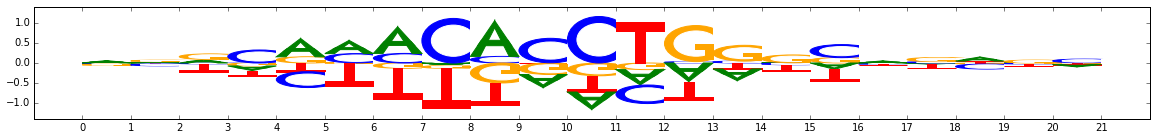

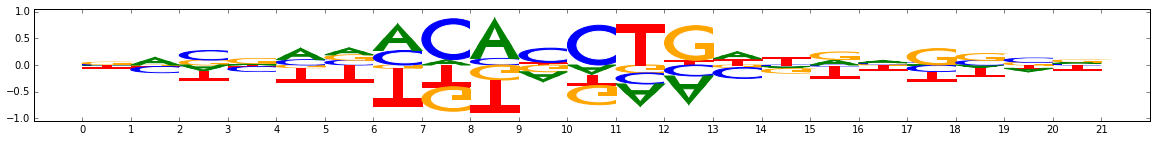

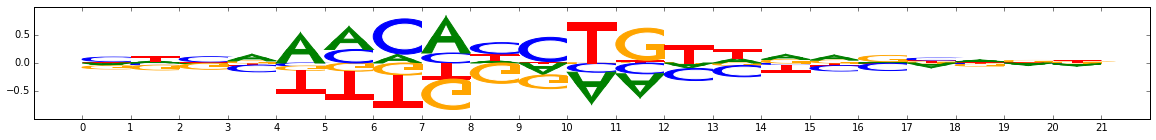

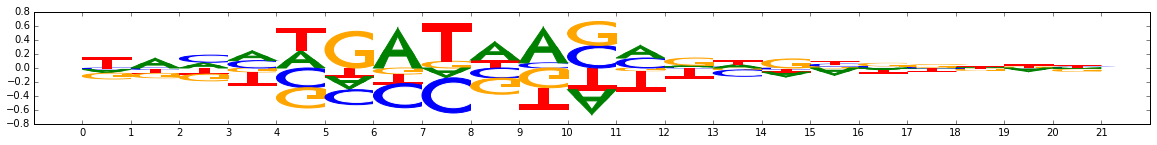

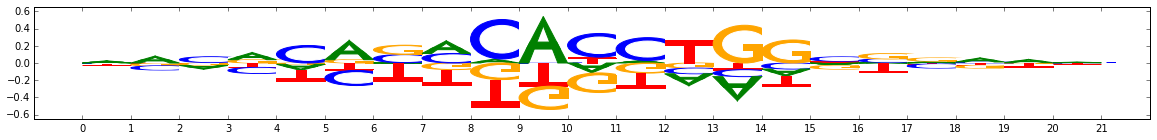

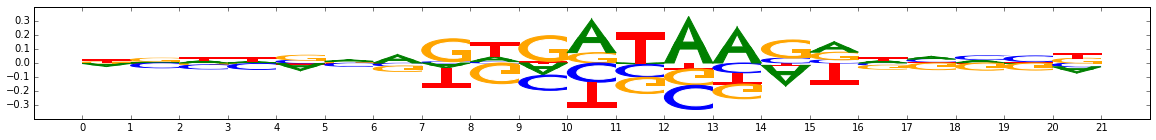

In [5]:
#sort the seqlets by their total DeepLIFT scores.
seqlets = sorted(seqlets, key=lambda x: -np.sum(x["deeplift_scores"].fwd))
#print 5 seqlets drawn from across the list, as a sanity check
for i in range(0,len(seqlets),int(len(seqlets)/5)):
    viz_sequence.plot_weights(seqlets[i]["multipliers"].fwd)

## Compute the affinity matrix

We now calculate an affinity matrix between all pairs of seqlets.

In this example, we will build the affinity matrix by taking the maximum cross-correlation as two seqlets are slid across each other. We do this by creating an instance of `MaxCrossCorrAffinityMatrixFromSeqlets`, which requires us to provide a `PatternCrossCorrSettings` object that describes the settings for doing the cross-correlation. The settings are:
- `track_names`, which is a list of tracks that we want to extract data from in order to do the cross-correlation. In this example, we just use the multipliers to do the cross-correlation, but it is possible to use other kinds of tracks (such as the importance scores of some intermediate convolutional layer).
- `normalizer`, which is an object that performs a normalization operation on the data extracted from each kind of track. In this case, the data is mean-normalized and then magnitude normalized (this is achieved by supplying a normalizer created by chaining a `MeanNormalizer` with a `MagnitudeNormalizer`).
- `min_overlap` specifies the minimum amount of overlap between the tracks required during the cross-correlation (the tracks are zero-padded to allow partial overlap). The minimum overlap is specified as a fraction of the total length of the tracks. In this case, the tracks must overlap by at least 30%.

In [6]:
from modisco import affinitymat as affmat
pattern_crosscorr_settings = affmat.PatternCrossCorrSettings(
                    track_names=["multipliers"],                                     
                    normalizer=affmat.MeanNormalizer().chain(affmat.MagnitudeNormalizer()),   
                    min_overlap=0.3)
affinity_mat_from_seqlets = affmat.MaxCrossCorrAffinityMatrixFromSeqlets(
                             pattern_crosscorr_settings=pattern_crosscorr_settings)
affinity_mat = affinity_mat_from_seqlets(seqlets)

On filters 0 to 11904
Done 0
Done 1000
On filters 0 to 11904
Done 0
Done 1000


## Cluster the affinity matrix

Having computed the affinity matrix, we are now prepared to do clustering. In this example, we apply PhenoGraph clustering (https://www.c2b2.columbia.edu/danapeerlab/html/phenograph.html). Briefly, PhenoGraph finds the `k` nearest neighbours for each point according to the supplied affinity matrix and constructs a graph where the edge weight between each pair of nodes is the jaccard distance between the sets of nearst neighbours of those nodes. Louvain community detection is then applied to the constructed graph.

Let us explore the results of PhenoGraph with different values of `k`:

In [7]:
from modisco.cluster import core as mclust
ks_to_try = [30, 100, 200, 400]
k_to_num_clusters = {}
k_to_cluster_results = {}
for k in ks_to_try:
    cluster_results = mclust.PhenographCluster(k=k).cluster(affinity_mat=affinity_mat)
    k_to_num_clusters[k] = max(cluster_results.cluster_indices)
    k_to_cluster_results[k] = cluster_results

Finding 30 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 0.260601997375 seconds
Jaccard graph constructed in 0.15623998642 seconds
Wrote graph to binary file in 0.0246419906616 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.896206
Louvain completed 21 runs in 0.36446595192 seconds
PhenoGraph complete in 0.819748163223 seconds
Finding 100 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 0.245009899139 seconds
Jaccard graph constructed in 0.81632399559 seconds
Wrote graph to binary file in 0.0707840919495 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.785872
Louvain completed 21 runs in 0.49196100235 seconds
PhenoGraph complete in 1.63991689682 seconds
Finding 200 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 0.393347024918 seconds
Jaccard graph constructed in 2.4773979187 seconds
Wrote graph t

Here are the numbers of clusters that resulted from the different values of `k`; lower values of `k` result in more clusters.

In [8]:
for k in ks_to_try:
    print("k: "+str(k)+", num_clusters: "+str(k_to_num_clusters[k]+1))

k: 30, num_clusters: 12
k: 100, num_clusters: 9
k: 200, num_clusters: 4
k: 400, num_clusters: 2


Let's nvestigate the results at `k=400`, which produced two clusters. We start by generating a tsne embedding of the affinity matrix and then coloring the tsne embedding according to the clusters obtained from PhenoGraph.

No colors supplied, so autogen'd as:
(0, (0, 1.0, 0.0))
(1, (0.5, 0, 0.5))


/Users/avantishrikumar/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:571: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


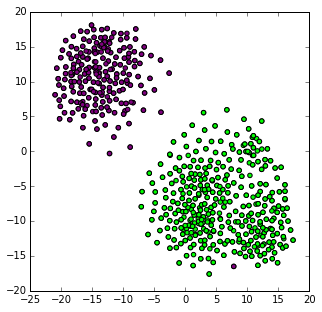

In [9]:
from modisco.visualization import tsne
reload(tsne)
import modisco
reload(modisco.visualization.matplotlibhelpers)

cluster_results = k_to_cluster_results[400]
embedding = tsne.get_tsne_embedding(affinity_mat=affinity_mat, perplexity=100)
tsne.color_tsne_embedding_by_clustering(embedding=embedding, clusters=cluster_results.cluster_indices)

It looks like PhenoGraph clustering at `k=400` successfully recapitulates the two clusters apparent in the tsne plot. Remember, tsne just produces an embedding; it does not produce clusters. Even if clusters are visually apparent from a tsne plot, it is still necessary to use a different clustering method to obtain them (of course, one can always use a tsne embedding as a preprocessing step for a clustering algorithm, but that is not necessary in this particular example)

## Aggregate seqlets within each cluster

We are now ready to aggregate the seqlets belonging to each cluser to obtain our motifs. In this case, we use a `HierarchicalSeqletAggregator` which works as follows:
- An affinity matrix is computed between all the seqlets using the function provided by `affinity_mat_from_seqlets`. This computation is done once at the beginning (the affinity matrix is not recomputed after every merging step).
- Starting with the closest pair of seqlets, seqlets are merged into an `AggregatedSeqlet` object. Merging is done by finding the best alignment of seqlets using the function provided by `pattern_aligner` (in our case, the pattern aligner finds the maximum cross-correlation using the same `pattern_cross_corr` settings as the ones used to build the affinity matrix).
- This `AggregatedSeqlet` object is then used in place of the original seqlet for successive merging steps. When two `AggregatedSeqlet` objects are merged together, the seqlets from the `AggregatedSeqlet` object that has fewer seqlets are added to the one with more seqlets, and are again aligned using the `pattern_aligner`.
- The process is terminated when all seqlets have been merged into a single `AggregatedSeqlet` object.

Although the `HierarchicalSeqletAggregator` currently aggregates all its provided seqlets into a single `AggregatedSeqlet`, I am leaving open the possibility of writing aggregators that can return mutliple `AggregatedSeqlets` (in effect doing subclustering during the aggregation). For this reason, the return type of the aggregator is a list, even though `HierarchicalSeqletAggregator` currently always returns a list with one element.


### A note on trimming

`AggregatedSeqlet` objects keep track of all the seqlets they are comprised of as well as the positions they aligned to. Each `AggregatedSeqlet` object has an attribute called `per_position_counts` which keeps track of how many seqlets overlap a particular position within the `AggregatedSeqlet`. They also support a trimming operation called `trim_to_positions_with_frac_support_of_peak` which can be used to discard positions on the flanks of the `AggregatedSeqlet` that very few seqlets aligned to. This trimming operation works as follows:
- The user provides an argument `frac` between 0.0 and 1.0
- The maximum number of seqlets overlapping a position in `per_position_counts` is identified. Call this quantity `max_count`
- The leftmost and rightmost indices in `per_position_counts` are identified such that `per_position_counts[index] >= frac*max_count`
- A new `AggregatedSeqlet` object is returned which contains only those seqlets that fall entirely within the bounds defined by the aforementioned left and right indices

In this example, we apply a trimming operation with `frac=0.2`

In [10]:
from modisco import aggregator
reload(aggregator)
reload(core)

#collect all the seqlets belonging to each cluster
from collections import defaultdict
cluster_to_seqlets = defaultdict(list)
for cluster_val, seqlet in zip(cluster_results.cluster_indices, seqlets):
    cluster_to_seqlets[cluster_val].append(seqlet)

#aggregate them. Seqlets are aggregated heirarchically and
#are aligned using maximum corss-correlation.
#We use the same pattern_cross_corr settings as before.
num_clusters = max(cluster_results.cluster_indices)+1
pattern_aligner = core.CrossCorrelationPatternAligner(
                        pattern_crosscorr_settings=pattern_crosscorr_settings)
seqlet_aggregator = aggregator.HierarchicalSeqletAggregator(
                                pattern_aligner=pattern_aligner,
                                affinity_mat_from_seqlets=affinity_mat_from_seqlets)
cluster_to_aggregated_seqlets = {}
for i in range(num_clusters):
    cluster_to_aggregated_seqlets[i] = [x.trim_to_positions_with_frac_support_of_peak(frac=0.2)
                                        for x in seqlet_aggregator(cluster_to_seqlets[i])]

On filters 0 to 11904
Done 0
On filters 0 to 11904
Done 0
On filters 0 to 11904
Done 0
On filters 0 to 11904
Done 0


Finally, let's visualize the patterns formed by aggregating seqlets in each cluster. For each `AggregatedSeqlet`, we can view the forward and reverse-complement versions of the pattern, the `per_position_counts`, as well as individual seqlets and their alignments.

Cluster 0:
per-position counts


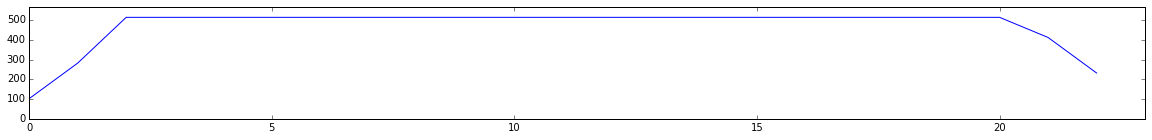

fwd:


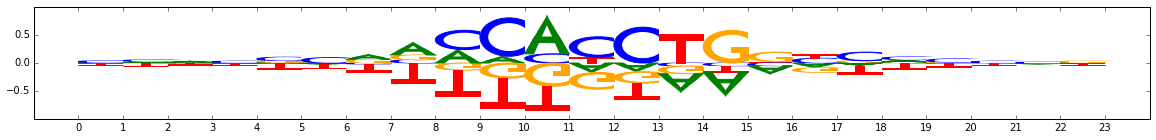

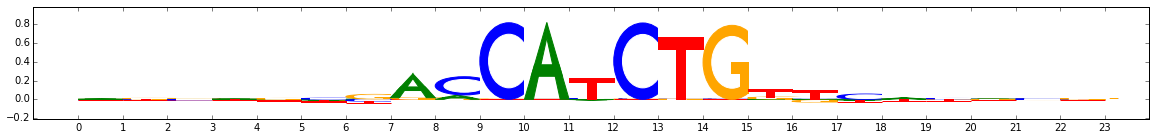

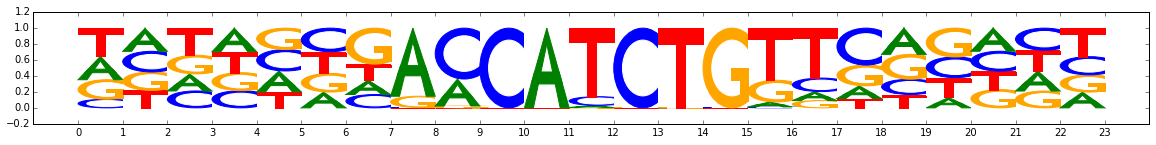

reverse:


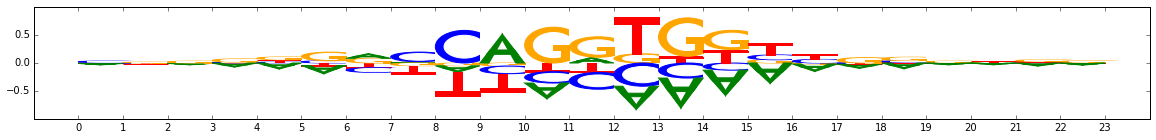

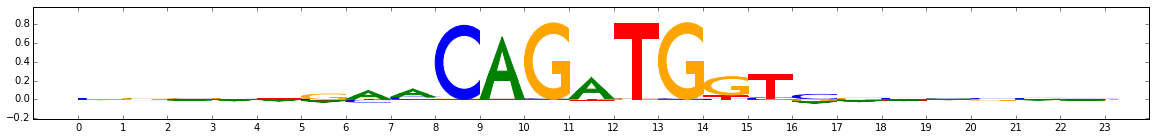

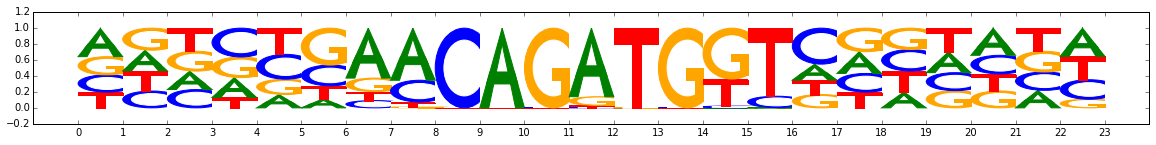

Individual seqlets and their alignments:
alignment: 2


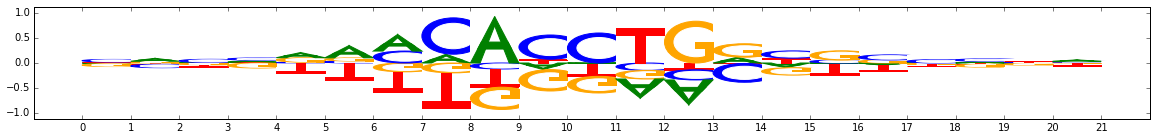

alignment: 2


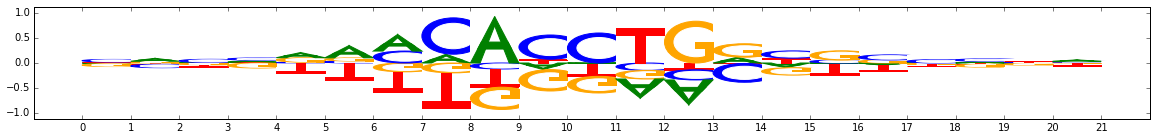

alignment: 1


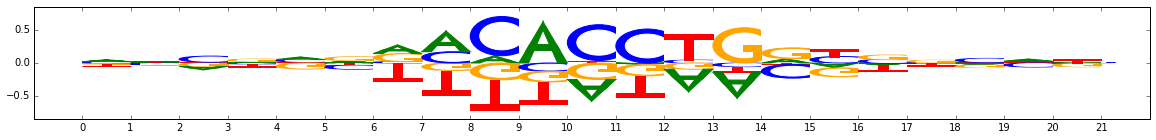

alignment: 1


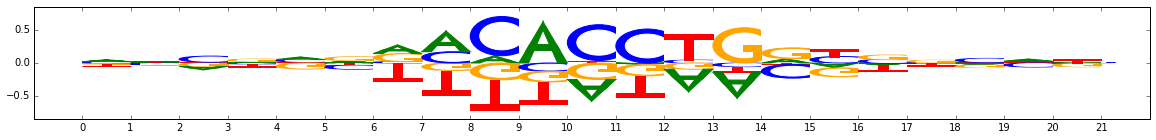

alignment: 2


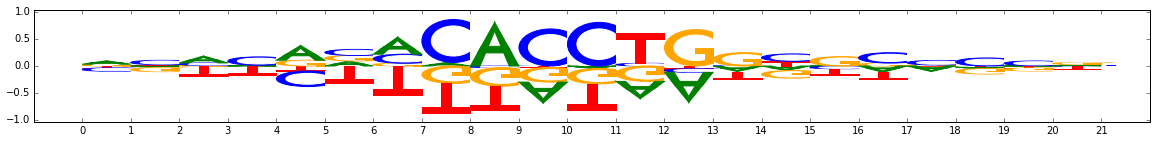

Cluster 1:
per-position counts


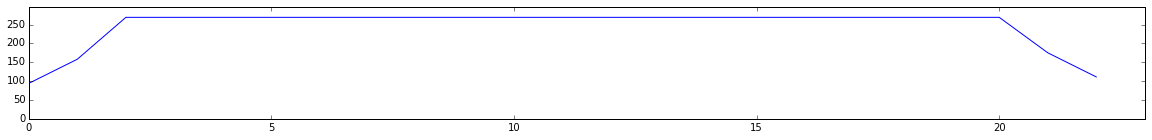

fwd:


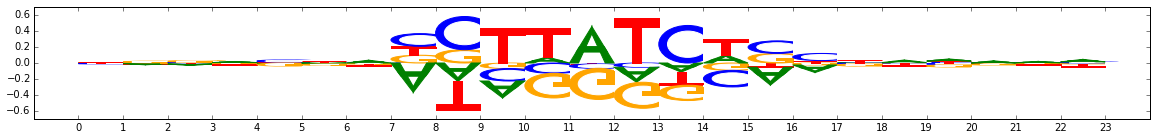

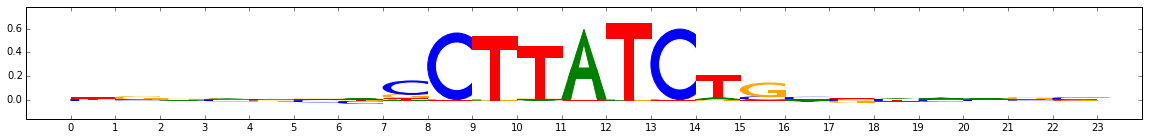

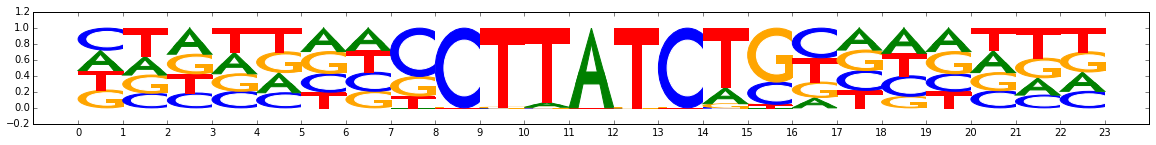

reverse:


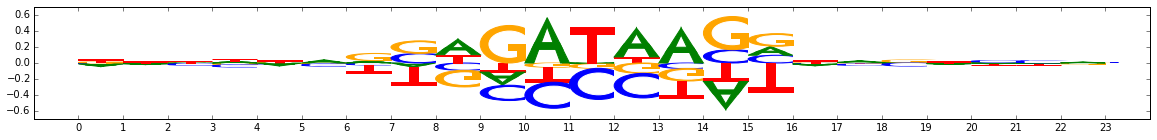

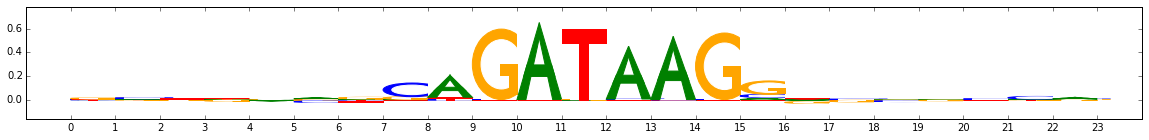

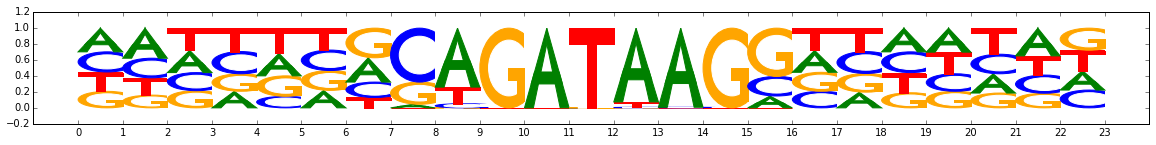

Individual seqlets and their alignments:
alignment: 1


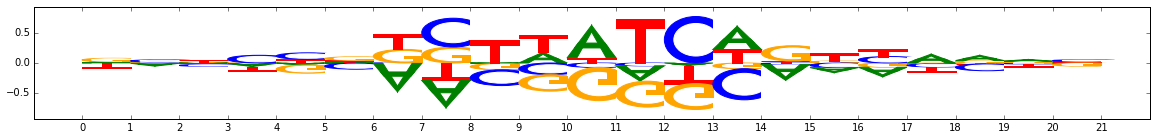

alignment: 1


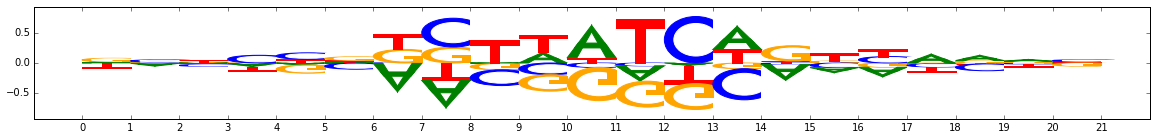

alignment: 1


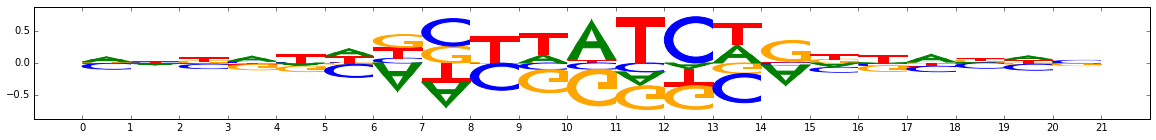

alignment: 2


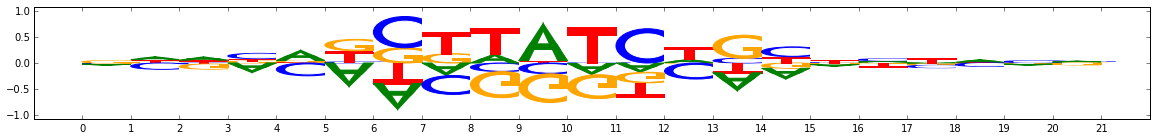

alignment: 2


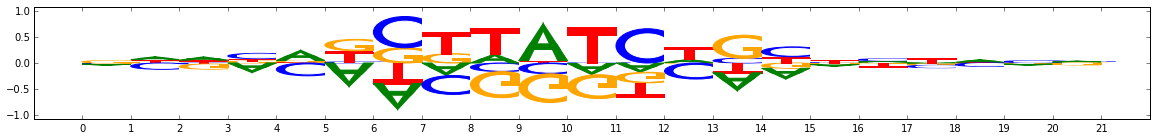

In [11]:
from matplotlib import pyplot as plt

for i in range(num_clusters):
    print("Cluster "+str(i)+":")
    #currently, aggregated_seqlets always has length 1 but leaving it flexible
    #so aggregator could return several motifs in the future
    for aggregated_seqlet in cluster_to_aggregated_seqlets[i]:
        print("per-position counts")
        aggregated_seqlet.plot_per_position_counts()
        print("fwd:")
        viz_sequence.plot_weights(aggregated_seqlet["multipliers"].fwd)
        viz_sequence.plot_weights(aggregated_seqlet["deeplift_scores"].fwd)
        viz_sequence.plot_weights(aggregated_seqlet["sequence"].fwd)
        print("reverse:")
        viz_sequence.plot_weights(aggregated_seqlet["multipliers"].rev)
        viz_sequence.plot_weights(aggregated_seqlet["deeplift_scores"].rev)
        viz_sequence.plot_weights(aggregated_seqlet["sequence"].rev)
        
        print("Individual seqlets and their alignments:")
        #view individual seqlets under the aggregated seqlet
        for seqlet_and_alnmt in aggregated_seqlet.seqlets_and_alnmts[:5]:
            print("alignment:",seqlet_and_alnmt.alnmt)
            viz_sequence.plot_weights(seqlet_and_alnmt.seqlet["multipliers"].fwd)